In [ ]:
# Import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import scipy.cluster.hierarchy as shc

# Import tools for visualizations
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter
from matplotlib.patches import ConnectionPatch
from matplotlib import patheffects

# Import algorithms, metrics for clustering.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

SEED=5
plt.style.use('ggplot')
plt.rc('axes', labelsize=10, labelweight='ultralight', titleweight='bold', titlesize='12',)
plt.rc('xtick', labelsize=9, )
plt.rc('ytick', labelsize=9, )

plotly.offline.init_notebook_mode()

feature_labels = {
    'Sex':['male','female'],
    'Marital status': ['single', 'non-single'],
    'Education':['other / unknown','high school','university','graduate school'],
    'Occupation':['unemployed / unskilled', 'skilled employee / official',
                  'self-employed / other'],
    'Settlement size':['small city', 'mid-sized city', 'big city']
}

In [ ]:
def plot_clusters3d(cluster_groups, cluster_col, title, colorscale=None, legend=True):
    '''
    Creates a 3D scatterplot of clusters. The color of data points is determined by colorscale parameter.
    '''
    # Create a figure.
    fig = go.Figure()

    # Plot scatter points for each cluster.
    for cluster in cluster_groups[cluster_col].unique():

        cluster_group = cluster_groups[cluster_groups[cluster_col] == cluster]

        trace = go.Scatter3d(x=cluster_group[0], y=cluster_group[1], z=cluster_group[2],
                             mode='markers', marker=dict(size=4 ,opacity=0.8, colorscale=colorscale),
                             legendwidth=2, name=cluster,)
        fig.add_trace(trace)

    fig.update_layout(showlegend=legend, width=700, height=600,
                      legend=dict(font=dict(size=20), itemsizing="constant", ),
                      title=dict(text=title, x=0.5))
    fig.show()


def colored_scatterplot(data, x, y, hue, color_palette='hls', **kwargs):
    '''
    Draw a scatterplot with hue being a grouping variable that will produce points with different colors.
    '''
    colors = sns.color_palette(color_palette, data[hue].nunique())


    groups = data.groupby(hue)

    # For each group plot the points with the corresponding color.
    for i, (name,group) in enumerate(groups):
        plt.plot(group[x], group[y], marker='o', linestyle='',label=name, c=colors[i], **kwargs)

    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(feature_labels.get(hue), title=hue)
    plt.grid(alpha=0.5)
    plt.title("{} vs {} w.r.t. {}".format(x, y, hue))


def stacked_countplot_with_labels(data, colors, xlabel, ylabel, ax, **kwargs):
    # Create a stacked countplot.
    ax = data.unstack().plot(kind='bar', stacked=True, color=colors, edgecolor='black', ax=ax,
                             xlabel=xlabel, ylabel=ylabel, **kwargs)


    for c in ax.containers:

        labels = [int(v.get_height()) if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', fontstyle='oblique',
                     fontvariant='small-caps', bbox=dict(facecolor='white',alpha=0.5,pad=1.6))
    return ax


def description(data):
    '''
    Returns the DataFrame representing a thorough description of the data.
    '''
    dtypes = data.dtypes
    counts = data.apply(lambda col: col.count())
    nulls = data.apply(lambda col: col.isnull().sum())
    nan_ratio = nulls / counts
    uniques = data.apply(lambda col: col.unique())
    n_uniques = data.apply(lambda col: col.nunique())
    maxs = data.apply(lambda col: col.max())
    mins = data.apply(lambda col: col.min())

    cols = {'dtypes':dtypes, 'counts':counts, 'nulls' : nulls, 'nan_ratio': nan_ratio,
            'max':maxs, 'min':mins,'n_uniques':n_uniques, 'uniques':uniques}
    return pd.DataFrame(data=cols)

In [ ]:
customer_data = pd.read_csv("/content/segmentation_data.csv")
data = customer_data.copy()
data

ID  Sex  Marital status  Age  Education  Income  Occupation  \
0     100000001    0               0   67          2  124670           1   
1     100000002    1               1   22          1  150773           1   
2     100000003    0               0   49          1   89210           0   
3     100000004    0               0   45          1  171565           1   
4     100000005    0               0   53          1  149031           1   
...         ...  ...             ...  ...        ...     ...         ...   
1995  100001996    1               0   47          1  123525           0   
1996  100001997    1               1   27          1  117744           1   
1997  100001998    0               0   31          0   86400           0   
1998  100001999    1               1   24          1   97968           0   
1999  100002000    0               0   25          0   68416           0   

      Settlement size  
0                   2  
1                   2  
2                   0  
3                   1  
4                   1  
...               ...  
1995                0  
1996                0  
1997                0  
1998                0  
1999                0  

[2000 rows x 8 columns]

In [ ]:
description(data)

dtypes  counts  nulls  nan_ratio        max        min  \
ID               int64    2000      0        0.0  100002000  100000001   
Sex              int64    2000      0        0.0          1          0   
Marital status   int64    2000      0        0.0          1          0   
Age              int64    2000      0        0.0         76         18   
Education        int64    2000      0        0.0          3          0   
Income           int64    2000      0        0.0     309364      35832   
Occupation       int64    2000      0        0.0          2          0   
Settlement size  int64    2000      0        0.0          2          0   

                 n_uniques                                            uniques  
ID                    2000  [100000001, 100000002, 100000003, 100000004, 1...  
Sex                      2                                             [0, 1]  
Marital status           2                                             [0, 1]  
Age                     58  [67, 22, 49, 45, 53, 35, 61, 28, 25, 24, 60, 3...  
Education                4                                       [2, 1, 0, 3]  
Income                1982  [124670, 150773, 89210, 171565, 149031, 144848...  
Occupation               3                                          [1, 0, 2]  
Settlement size          3                                          [2, 0, 1]

In [ ]:
# Change the type of categorical features from numerical to category.
for col in ['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']:
    data[col] = data[col].astype('category')

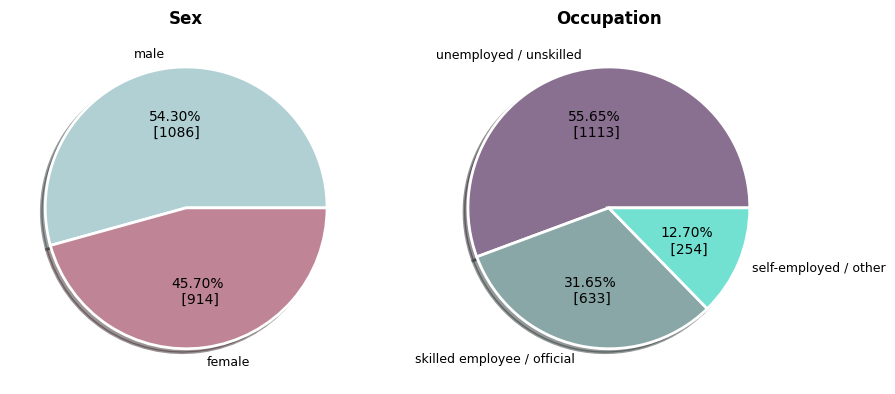

In [ ]:
plt.figure(figsize=(10,5))

# Pie chart for Gender
plt.subplot(121, title='Sex')
plt.pie(data['Sex'].value_counts(), labels=feature_labels['Sex'],
        autopct=lambda val: '{:1.2f}%\n [{:.0f}]'.format(val,
                                        val * data['Sex'].value_counts().sum() / 100),
        colors = ["#B0D0D3", "#C08497"],
        wedgeprops=dict(width=1, edgecolor='white',linewidth=2), shadow=True,)

# Pie chart for Occupation
plt.subplot(122, title='Occupation')
plt.pie(data['Occupation'].value_counts(), labels=feature_labels['Occupation'],
        autopct=lambda val: '{:1.2f}%\n [{:.0f}]'.format(val,
                                        val * data['Occupation'].value_counts().sum() / 100),
        colors = ["#8a7090", "#89A7A7", "#72E1D1"],
        wedgeprops=dict(width=1, edgecolor='white',linewidth=2), shadow=True,)

plt.show()

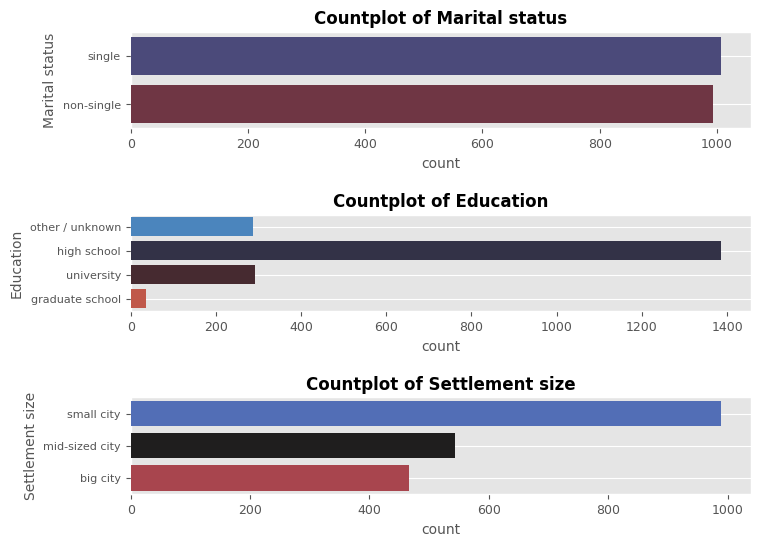

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(8,6))
plt.subplots_adjust(hspace=0.9, wspace=0.4)

for i, feature in enumerate(['Marital status', 'Education', 'Settlement size']):
    plt.subplot(3,1,i+1)
    sns.countplot(data=data, y=feature, palette='icefire', width=0.8, zorder=3,)
    plt.gca().set_yticklabels(feature_labels[feature], fontsize=8)
    plt.grid()
    plt.title('Countplot of {}'.format(feature))

In [ ]:
# Change the scale of the Income feature, convert the values to thousands of dol. instead of just dol.
data['Income'] = data['Income']/1e3

# The median income
data.Income.median()

115.5485

Text(0.5, 1.0, 'Income Distribution')

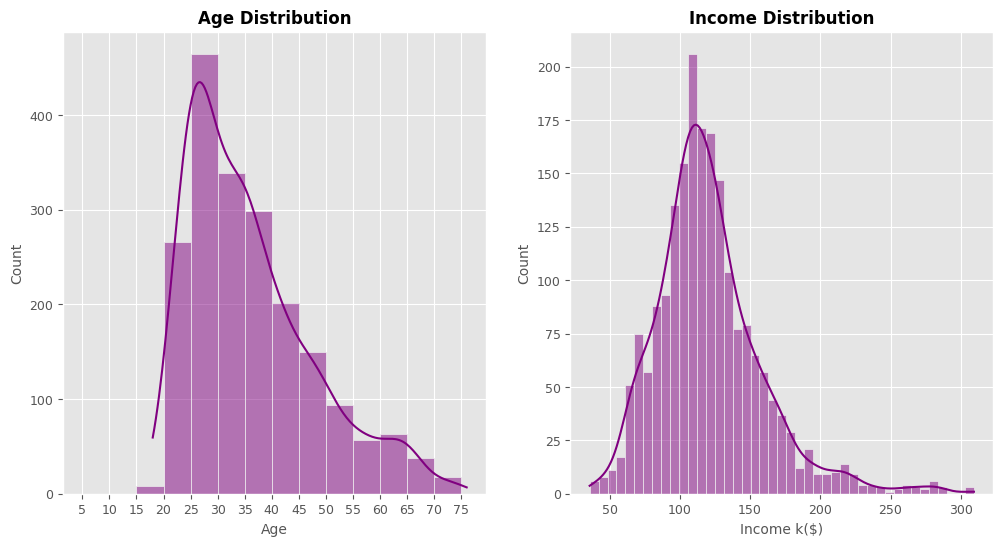

In [ ]:
fig = plt.figure(figsize=(12,6))

plt.subplot(121)
sns.histplot(data=data, x='Age', bins=np.arange(5,80,5),kde=True,color='purple')
plt.gca().xaxis.set_major_locator(MultipleLocator(5))
plt.title('Age Distribution')

plt.subplot(122)
sns.histplot(data=data, x=data['Income'],color='purple',kde=True,)
plt.xlabel('Income k($)')
plt.title('Income Distribution')

Text(0.5, 0.98, 'Distribution of Age')

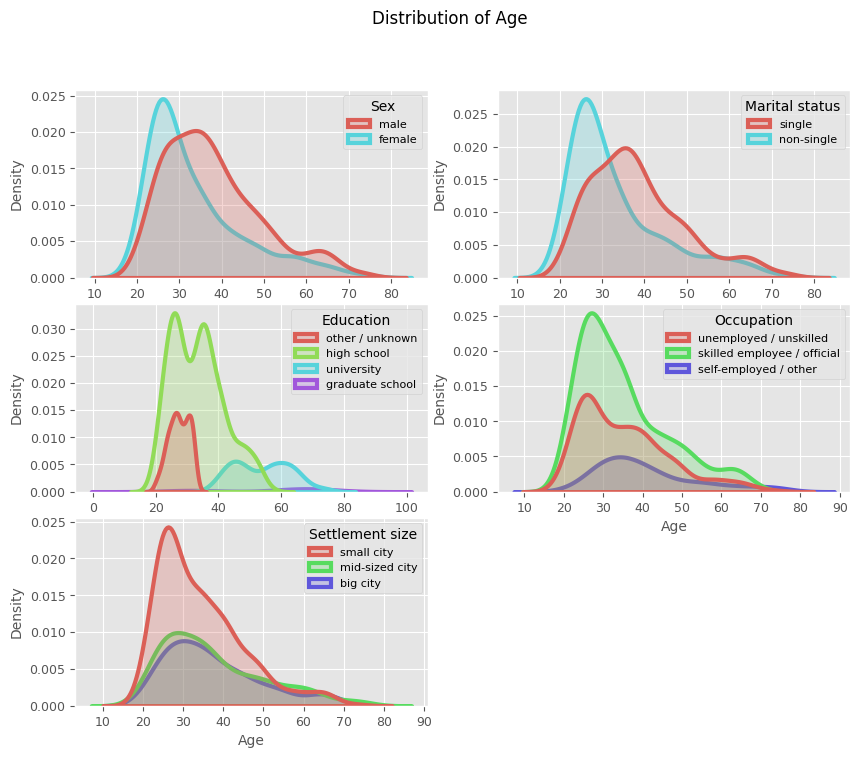

In [ ]:
plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.14)

# Distribution plots for Age w.r.t. to other features.
for i, col in enumerate(['Sex', 'Marital status', 'Education','Occupation', 'Settlement size']):
    plt.subplot(3,2,i+1)
    g = sns.kdeplot(data=data, x='Age', hue=col, palette='hls',linewidth=3, fill=True, )

    # Update the legend.
    for t, l in zip(g.legend_.texts, feature_labels[col]):
        t.set_text(l)
    sns.move_legend(g, "upper right", fontsize=8)

plt.suptitle('Distribution of Age')

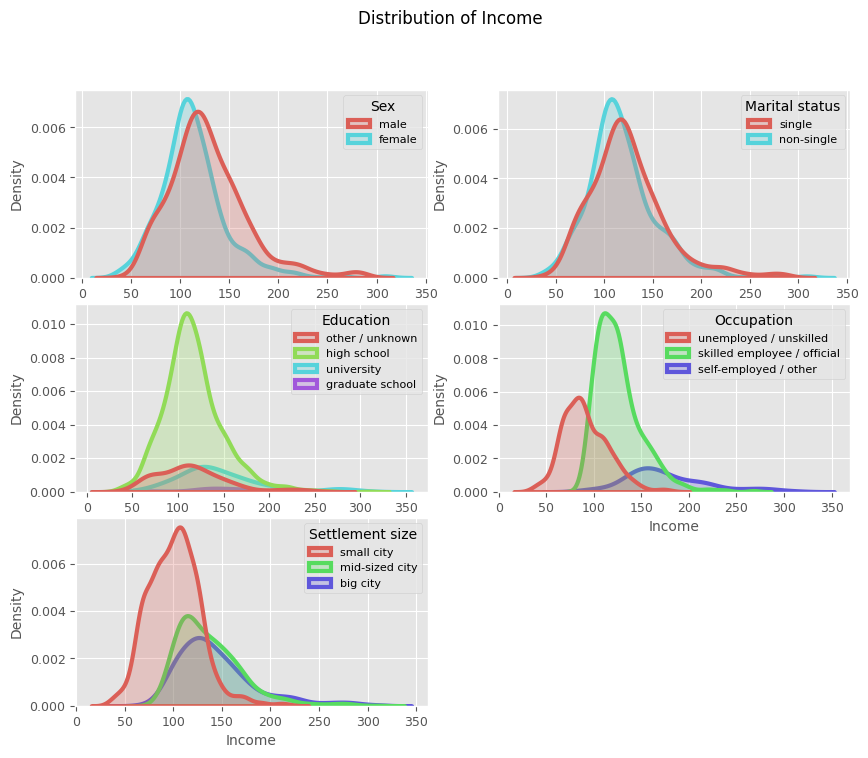

In [ ]:
plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.14)

# Distribution plots for Income w.r.t to other features.
for i, col in enumerate(['Sex', 'Marital status', 'Education','Occupation', 'Settlement size']):
    plt.subplot(3,2,i+1,)
    g = sns.kdeplot(data=data, x='Income', hue=col, palette='hls',linewidth=3, fill=True, )

    # Update the legend.
    g.legend_.set_title(col)
    for t, l in zip(g.legend_.texts, feature_labels[col]):
        t.set_text(l)
    sns.move_legend(g, "upper right", fontsize=8)

plt.suptitle('Distribution of Income');

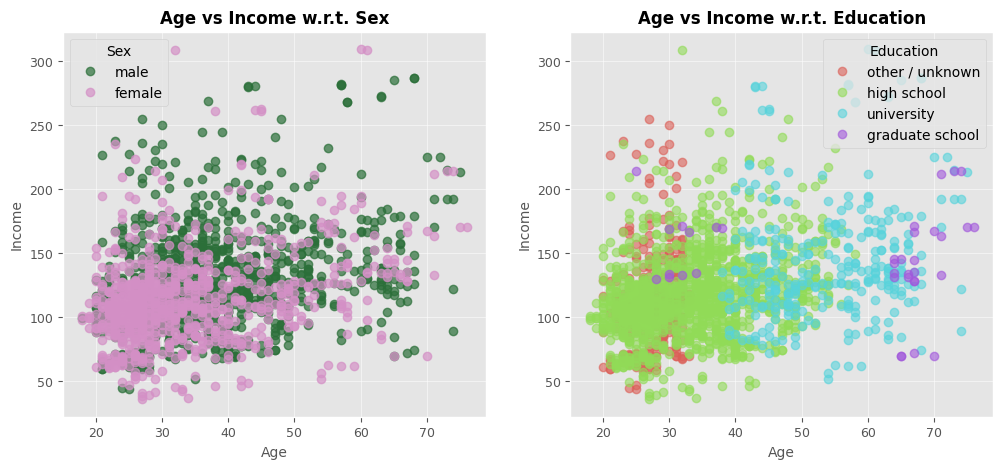

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

plt.subplot(121)
colored_scatterplot(data, x='Age', y='Income', hue='Sex', color_palette='cubehelix', alpha=0.7, )

plt.subplot(122)
colored_scatterplot(data, x='Age', y='Income', hue='Education', color_palette='hls', alpha=0.6)

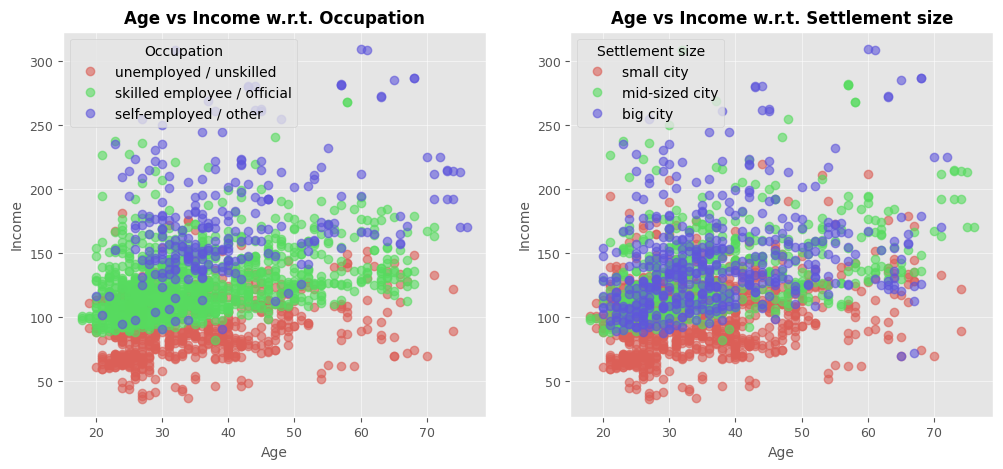

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

plt.subplot(121)
colored_scatterplot(data, x='Age', y='Income', hue='Occupation', color_palette='hls', alpha=0.6)

plt.subplot(122)
colored_scatterplot(data, x='Age', y='Income', hue='Settlement size', alpha=0.6)

In [ ]:
#Dimensionality Reduction
# Scaling the data
std = StandardScaler()
data_std = pd.DataFrame(std.fit_transform(data), columns=data.columns)

# Reducing dimensions to 3.
pca = PCA(n_components=3, random_state=SEED)
data_reduced = pd.DataFrame(pca.fit_transform(data_std),)

data_reduced.head()

0         1         2
0  2.859782  0.936676  2.036586
1  0.944130  0.394492 -2.433785
2 -0.023032 -0.881797  1.974083
3  2.212422 -0.563616  0.635332
4  2.110202 -0.425124  1.127543

In [ ]:
# Create a scatterplot.
trace = go.Scatter3d(x=data_reduced[0], y=data_reduced[1], z=data_reduced[2], mode='markers',
                     marker=dict(size=3 ,opacity=0.8, color='green'),)

layout = go.Layout(title=dict(text='The 3D Data', x=0.5), width=600, height=600)
fig = go.Figure(data=[trace], layout=layout)

fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

Text(0, 0.5, 'Inertia')

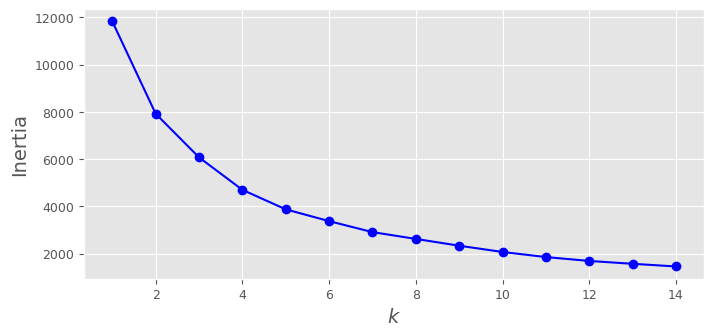

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=SEED).fit(data_reduced) for k in range(1,15)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1,15), inertias, "bo-")

plt.xlabel('$k$', fontsize=14)
plt.ylabel('Inertia', fontsize=14)

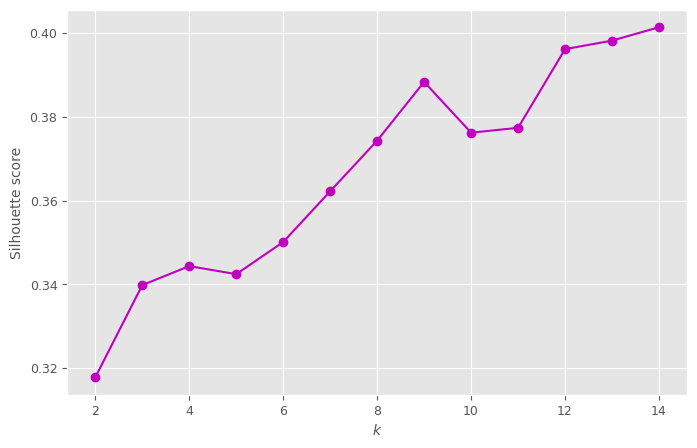

In [ ]:
silhouette_scores = [silhouette_score(data_reduced, model.labels_, random_state=SEED)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8,5))
plt.plot(range(2,15),silhouette_scores,'mo-')
plt.xlabel("$k$", )
plt.ylabel("Silhouette score", )
plt.grid(True)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=SEED)
data['kmeans_cluster'] = kmeans.fit_predict(data_reduced) # Fit the model and predict clusters
data['kmeans_cluster'] = data['kmeans_cluster'].astype('category')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
temp = data_reduced.copy()
cluster_col = 'kmeans_cluster'
temp[cluster_col] = data[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (KMeans)')

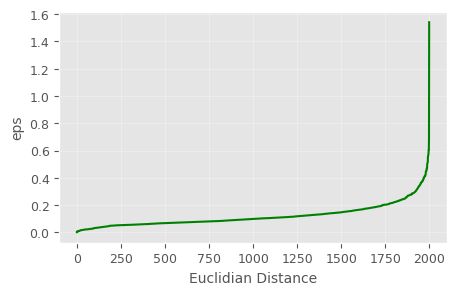

In [ ]:
#DBSCAN
nn = NearestNeighbors(n_neighbors=10).fit(data_reduced)

# Calculate the average distance between each point and its k-nearest neighbors
distances, indices = nn.kneighbors(data_reduced)

# Plot number of points vs average distance. Find the elbow (eps is the y-value)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(5,3))
plt.plot(distances, c='green', )
plt.xlabel('Euclidian Distance')
plt.ylabel('eps')
plt.grid(alpha=0.3)

In [ ]:
#Fitting DBSCAN with best parameters
dbscan = DBSCAN(eps=0.7, min_samples=22).fit(data_reduced)
pred_labels = dbscan.labels_
data['db_cluster'] = dbscan.labels_
data['db_cluster'] = data['db_cluster'].astype('category')

print(f"Number of clusters: {len(np.unique(pred_labels))} \
      \nNumber of outliers: {len(pred_labels[pred_labels==-1])}")

Number of clusters: 6       
Number of outliers: 178


In [ ]:
temp = data_reduced.copy()
cluster_col = "db_cluster"
temp[cluster_col] = data[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (DBSCAN)')

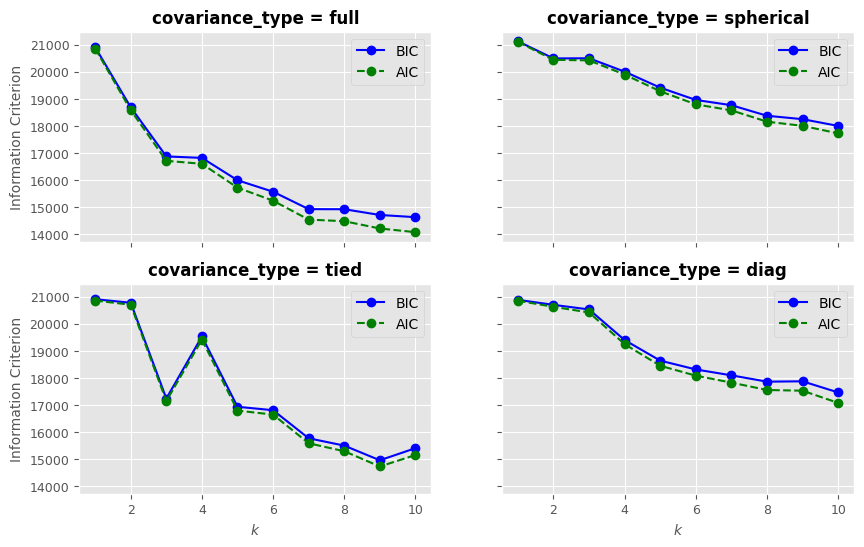

In [ ]:
#Gaussian Mixture
fig, axs = plt.subplots(2,2,figsize=(10,6), sharex=True, sharey=True)

for i, cov in enumerate(['full','spherical', 'tied', 'diag']):
    gms_per_k = [GaussianMixture(n_components=k,n_init=10, covariance_type=cov,random_state=SEED)\
                 .fit(data_reduced) for k in range(1,11)]
    bics = [model.bic(data_reduced) for model in gms_per_k]
    aics = [model.aic(data_reduced) for model in gms_per_k]

    plt.subplot(2,2,i+1)
    plt.plot(range(1,11), bics, "bo-", label="BIC")
    plt.plot(range(1,11), aics, "go--", label="AIC")

    plt.title("covariance_type = {}".format(cov))
    plt.xlabel('$k$') if i in(2,3) else plt.xlabel('')
    plt.ylabel('Information Criterion') if i in(0,2) else plt.ylabel('')
    plt.grid(True)
    plt.legend()

In [ ]:
min_bic = np.infty

for k in range(1,11):
    for cov in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10, covariance_type=cov, random_state=SEED)\
                             .fit(data_reduced).bic(data_reduced)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = cov

best_k, best_covariance_type

(10, 'full')

In [ ]:
gm = GaussianMixture(n_components=7, n_init=10, covariance_type='tied',random_state=SEED)
data['gm_cluster'] = gm.fit_predict(data_reduced)
data['gm_cluster'] = data['gm_cluster'].astype('category')

In [ ]:
temp = data_reduced.copy()
cluster_col = "gm_cluster"
temp[cluster_col] = data[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (GaussianMixture)')


Text(0.5, 1.0, 'Distribution of Clusters')

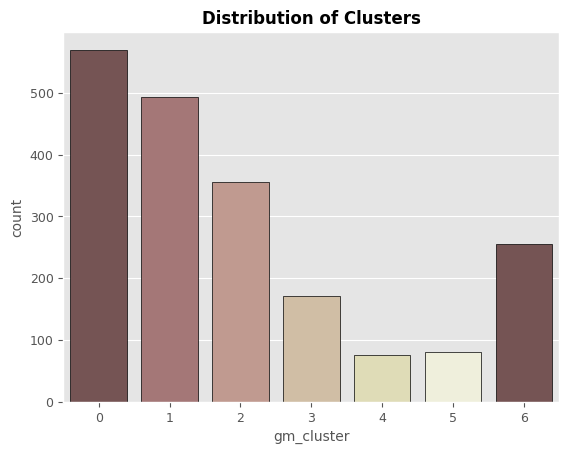

In [ ]:
sns.countplot(x=data['gm_cluster'], palette=sns.color_palette("pink"), edgecolor='black')
plt.title('Distribution of Clusters')

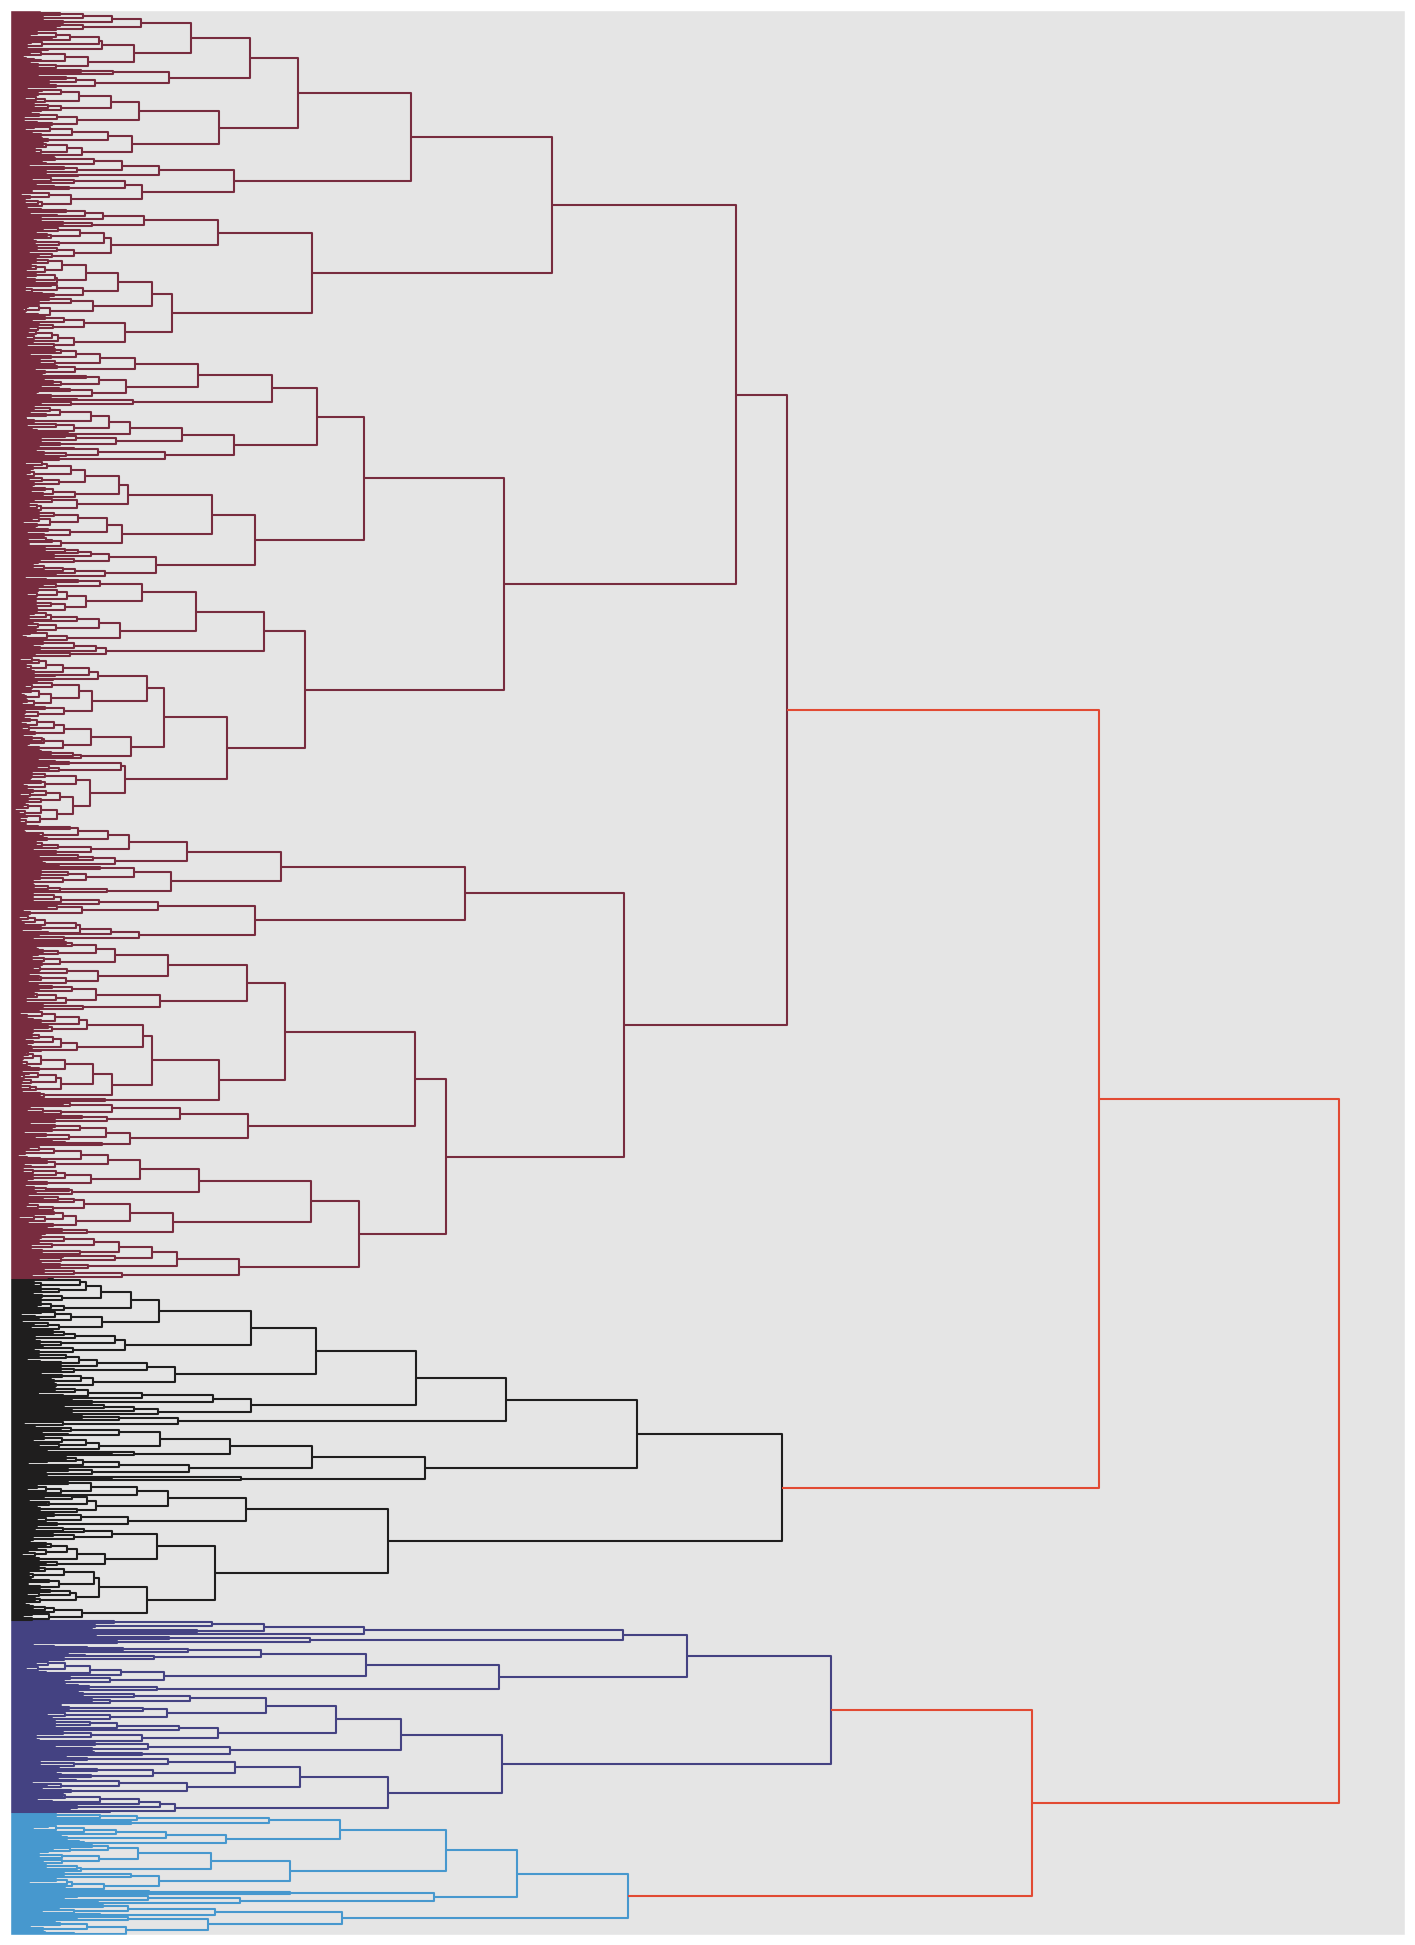

In [ ]:
#Agglomerative Clustering
# Dendogram for Heirarchial Clustering
plt.figure(figsize=(18,25))
shc.set_link_color_palette(['#4798ce', '#444282', '#1f1e1e', '#782c3f', '#e25f33'])
dend = shc.dendrogram(shc.linkage(data_reduced, method='complete'),orientation='right',)

plt.gca().set(xticks=[], yticks=[])
plt.show()

In [ ]:
#Fitting the AgglomerativeClustering with the best parameters
agglom = AgglomerativeClustering(n_clusters=5, linkage='complete',)
data['agg_cluster'] = agglom.fit_predict(data_reduced)
data['agg_cluster'] = data['agg_cluster'].astype('category')

In [ ]:
temp = data_reduced.copy()
cluster_col = "agg_cluster"
temp[cluster_col] = data[cluster_col].copy()
temp.sort_values(by=cluster_col, inplace=True)

plot_clusters3d(cluster_groups=temp, cluster_col=cluster_col, colorscale='rainbow',
                title='The Plot of Clusters (AgglomerativeClustering)')

Text(0.5, 1.0, 'Distribution of Clusters')

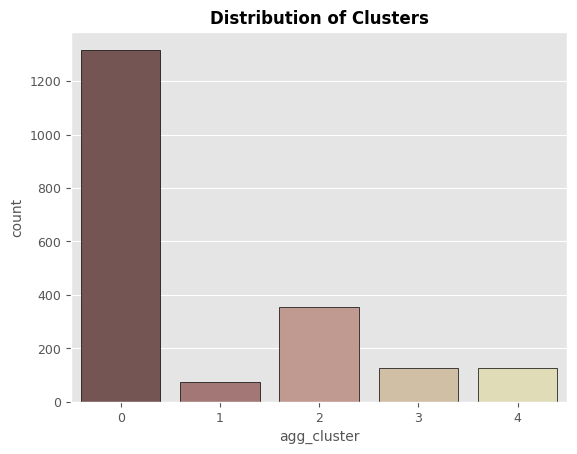

In [ ]:
%matplotlib inline

sns.countplot(x=data['agg_cluster'], palette=sns.color_palette("pink"), edgecolor='black')
plt.title('Distribution of Clusters')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

data_scaled=customer_data.copy()

# Define the features and the target
X = data_scaled[['Sex', 'Marital status', 'Age', 'Education', 'Occupation', 'Settlement size']]
y = data_scaled['Income']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))

# Output the RMSE to evaluate the model
print('Root Mean Squared Error (RMSE) on test set:', rmse)

Root Mean Squared Error (RMSE) on test set: 25907.6715578066


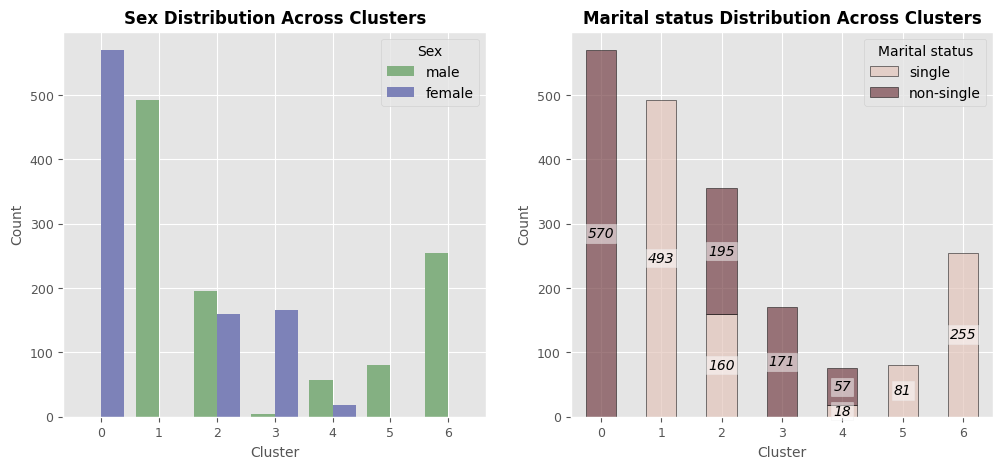

In [ ]:
#Customer Profiling
plt.figure(figsize=(12,5))

plt.subplot(121, title='Sex Distribution Across Clusters')
group = data[['ID','Sex', 'gm_cluster']].groupby(['gm_cluster','Sex']).count()
group.unstack().plot(kind='bar', xlabel='Cluster', ylabel='Count', ax=plt.gca(),
                     color=['#84B082','#7D82B8'], width=0.8)

# Replacing dummies with categorical values.
plt.legend(feature_labels['Sex'], loc='upper right', title='Sex', frameon=True)
plt.xticks(rotation=0)


plt.subplot(122, title='Marital status Distribution Across Clusters')
stacked_countplot_with_labels(
    data=data[['ID','Marital status', 'gm_cluster']].groupby(['gm_cluster','Marital status']).count(),
    colors=['#E3C5BB', '#764248'], xlabel='Cluster', ylabel='Count', ax=plt.gca(), alpha=.7
)
# Replacing dummies with categorical values.
plt.legend(feature_labels.get('Marital status'), loc='upper right', title='Marital status', frameon=True)
plt.xticks(rotation=0)
plt.show();

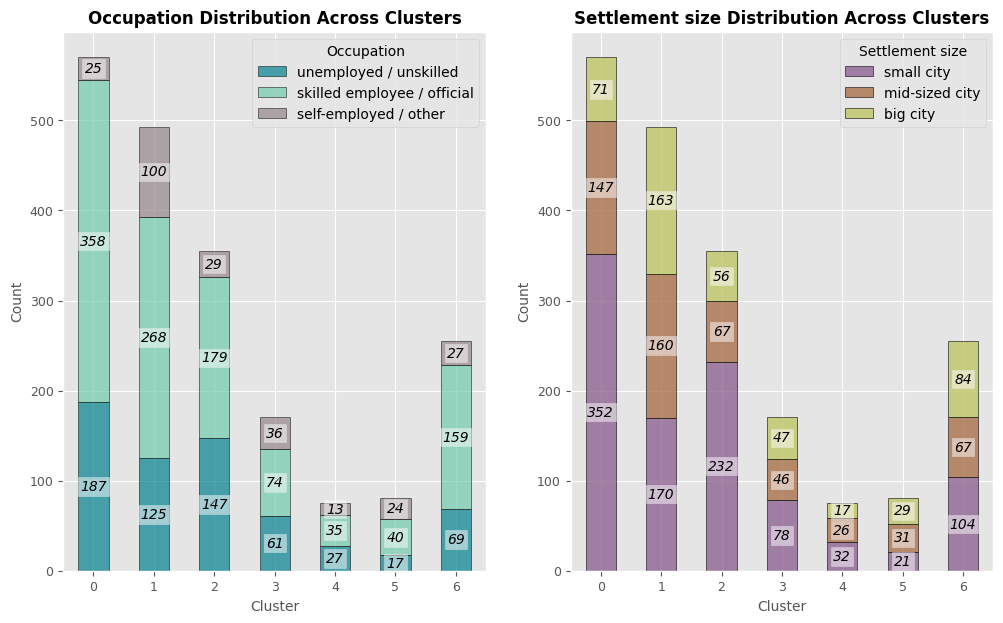

In [ ]:
plt.figure(figsize=(12,7))
plt.subplot(121, title='Occupation Distribution Across Clusters')
colors = ['#028090', '#71cbab','#958489']
stacked_countplot_with_labels(
    data=data[['ID','Occupation', 'gm_cluster']].groupby(['gm_cluster','Occupation']).count(),
    colors=colors, xlabel='Cluster', ylabel='Count', ax=plt.gca(), alpha=.7
)
# Replacing dummies with categorical values.
plt.legend(feature_labels.get('Occupation'), loc='upper right', title='Occupation', frameon=True)
plt.xticks(rotation=0)

plt.subplot(122, title='Settlement size Distribution Across Clusters')
colors = ['#8F6593', '#A9714B','#bdc667']
stacked_countplot_with_labels(
    data=data[['ID','Settlement size', 'gm_cluster']].groupby(['gm_cluster','Settlement size']).count(),
    colors=colors, xlabel='Cluster', ylabel='Count', ax=plt.gca(), alpha=.8,
)
# Replacing the dummies with categorical values.
plt.legend(feature_labels.get('Settlement size'), loc='upper right', title='Settlement size', frameon=True)
plt.xticks(rotation=0);

In [ ]:
def bar_of_pie_chart(cluster_members, age_per_cluster, cluster_number):
    # make figure and assign axis objects
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
    fig.subplots_adjust(wspace=0)

    # pie chart parameters
    overall_ratios = cluster_members.percent.values
    labels = cluster_members.index
    explode = [0]*len(labels)
    explode[cluster_number] = 0.1
    colors = sns.color_palette('hls', len(labels))

    # rotate so that the wedge is split by the x-axis
    angle = -180*overall_ratios[0]
    if cluster_number > 0:
        angle -=52 * cluster_number

    wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                         labels=labels, explode=explode, colors=colors,
                         wedgeprops=dict(edgecolor='white', linewidth=0.7), shadow=True)

    # bar chart parameters
    age_ratios = age_per_cluster.percent.loc[cluster_number].values
    age_labels = age_per_cluster.percent.loc[cluster_number].index.values
    bottom = 1
    width = .2

    # Adding from the top matches the legend.
    for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
        if height == 0:   # don't show the label in legend and values on the bar if there are no people in this age group.
            continue
        bottom -= height
        bc = ax2.bar(0, height, width, bottom=bottom, color='b', label=label,
                     alpha= 0.15 + 0.15 * j)
        ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center', color='black',
                      fontweight='black',)

    ax2.set_title('Age of customers')
    ax2.legend()
    ax2.axis('off')
    ax2.set_xlim(- 2.5 * width, 2.5 * width)

    # use ConnectionPatch to draw lines between the two plots
    theta1, theta2 = wedges[cluster_number].theta1, wedges[cluster_number].theta2
    center, r = wedges[cluster_number].center, wedges[cluster_number].r
    bar_height = sum(age_ratios)

    # draw top connecting line
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = r * np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    con.set_linewidth(2)
    ax2.add_artist(con)

    # draw bottom connecting line
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = r * np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                          xyB=(x, y), coordsB=ax1.transData)
    con.set_color([0, 0, 0])
    ax2.add_artist(con)
    con.set_linewidth(2)

In [ ]:
group = data[['ID','Age', 'gm_cluster']].sort_values(by='gm_cluster')

# Group Age feature into a few categories.
max_age = group['Age'].max()
group['Age'].replace(range(15,25), "Under 25", inplace=True)
group['Age'].replace(range(25,35), "25-34", inplace=True)
group['Age'].replace(range(35,45), "35-44", inplace=True)
group['Age'].replace(range(45,61), "45-60", inplace=True)
group['Age'].replace(range(61, max_age+1), "Over 60", inplace=True)

# Cluster & Age count and percents
age_per_cluster = group.groupby(['gm_cluster','Age']).count()
age_per_cluster.rename(columns={'ID':'count'}, inplace=True)
age_per_cluster['percent'] = age_per_cluster.groupby(level=0).transform(lambda x:
                                                                        (x / x.sum()).round(2))

# Cluster count and percents
cluster_members = data[['gm_cluster','ID']].groupby(['gm_cluster']).count()
cluster_members.rename(columns={'ID':'count'}, inplace=True)
cluster_members['percent'] = cluster_members['count'] / cluster_members['count'].sum()

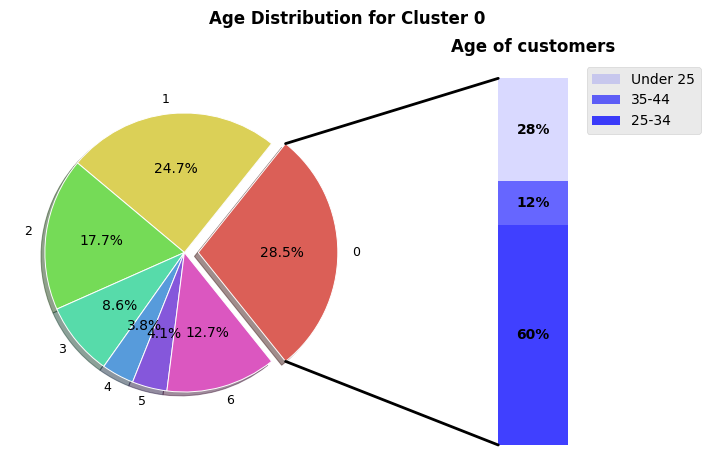

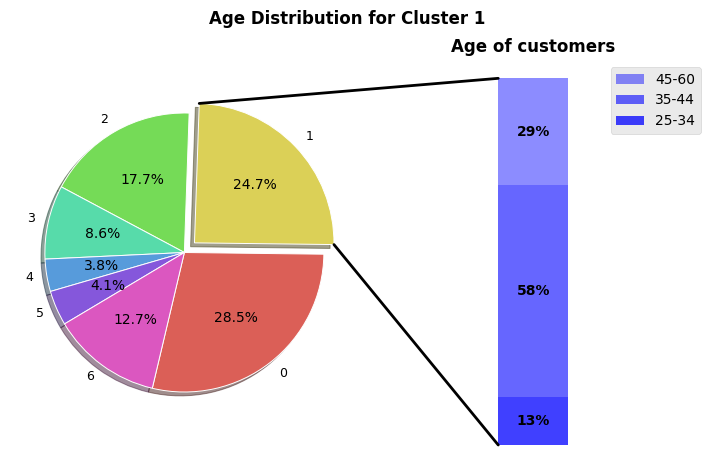

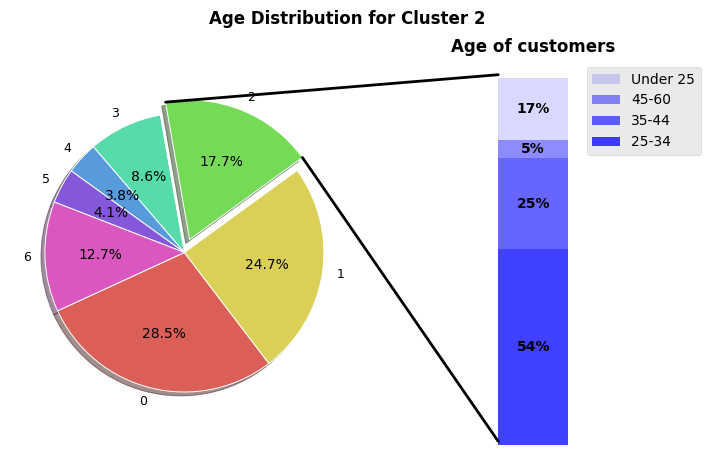

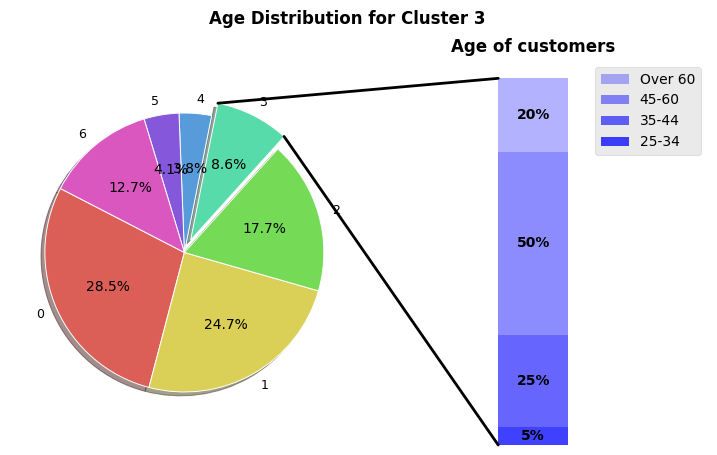

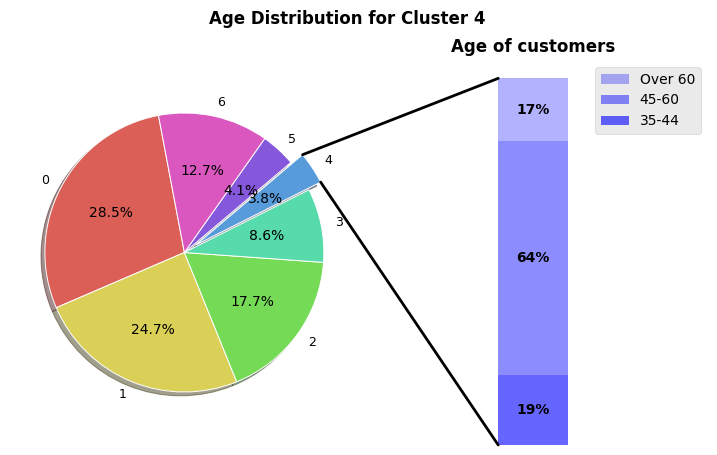

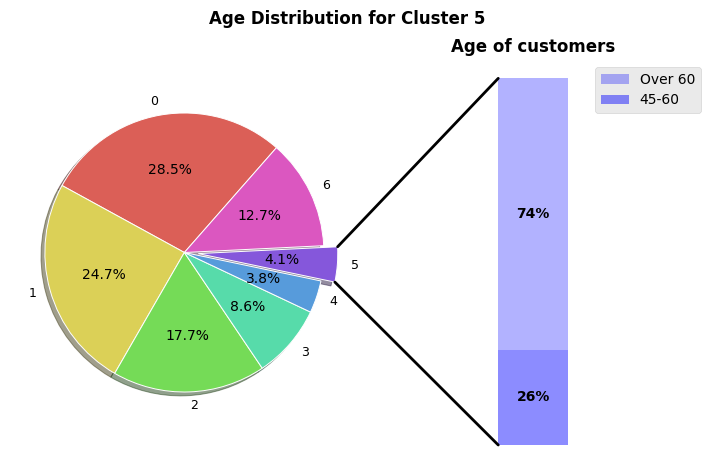

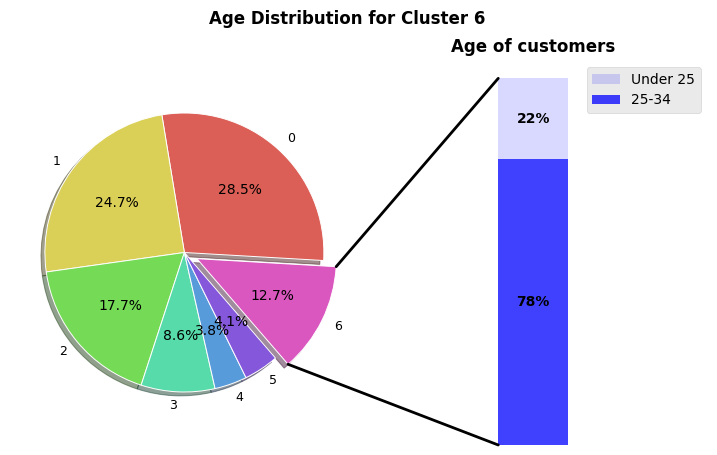

In [ ]:
# Let's see what age groups each cluster consists of.
for k in range(7):
    bar_of_pie_chart(cluster_members, age_per_cluster, cluster_number=k)
    plt.suptitle("Age Distribution for Cluster {}".format(k), fontweight='bold')

[Text(0, 0.5, 'Number of Customers'), Text(0.5, 0, 'Cluster')]

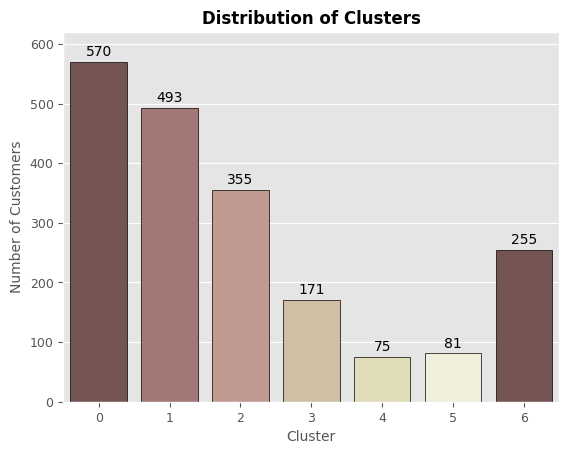

In [ ]:
plt.subplot(111, title='Distribution of Clusters', ylim=(0,620))
ax = sns.countplot(x=data['gm_cluster'], palette=sns.color_palette("pink"), edgecolor='black')

# Adding labels
for rect, label in zip(ax.patches, pd.DataFrame(data[['gm_cluster']].value_counts()).sort_values(by='gm_cluster').values.flatten()):
    height=rect.get_height()
    ax.text(rect.get_x()+rect.get_width()*0.5, height+10, label, ha='center')
ax.set(ylabel='Number of Customers', xlabel='Cluster')